# Image generation with Stable Diffusion XL and OpenVINO

Stable Diffusion XL or SDXL is the latest image generation model that is tailored towards more photorealistic outputs with more detailed imagery and composition compared to previous Stable Diffusion models, including Stable Diffusion 2.1.

With Stable Diffusion XL you can now make more realistic images with improved face generation, produce legible text within images, and create more aesthetically pleasing art using shorter prompts.

![pipeline](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/resolve/main/pipeline.png)

[SDXL](https://arxiv.org/abs/2307.01952) consists of an [ensemble of experts](https://arxiv.org/abs/2211.01324) pipeline for latent diffusion: In the first step, the base model is used to generate (noisy) latents, which are then further processed with a refinement model specialized for the final denoising steps. Note that the base model can be used as a standalone module or in a two-stage pipeline as follows: First, the base model is used to generate latents of the desired output size. In the second step, we use a specialized high-resolution model and apply a technique called [SDEdit](https://arxiv.org/abs/2108.01073)( also known as "img2img") to the latents generated in the first step, using the same prompt. 

In this tutorial, we consider how to run SDXL model using OpenVINO.

## Prerequisites

In [1]:
!pip install -q "git+https://github.com/huggingface/optimum-intel.git"
!pip install -q --upgrade-strategy eager "diffusers>=0.18.0" "invisible-watermark>=0.2.0" "transformers>=4.30.2" "accelerate" "onnx" "onnxruntime" "openvino>=2023.0.0"

## SDXL Base model

In [2]:
from pathlib import Path
from optimum.intel.openvino import OVStableDiffusionXLPipeline
import gc

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
model_dir = Path("openvino-sd-xl-base-1.0")
if not model_dir.exists():
    base = OVStableDiffusionXLPipeline.from_pretrained(model_id, export=True, compile=False)
    base.save_pretrained(model_dir)
    del base
    gc.collect()

2023-07-28 15:01:35.180239: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-28 15:01:35.220852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 15:01:36.027433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


### Run Text2Image generation pipeline

In [3]:
text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir)

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder_2...
Compiling the text_encoder...
Compiling the vae_encoder...


  0%|          | 0/15 [00:00<?, ?it/s]

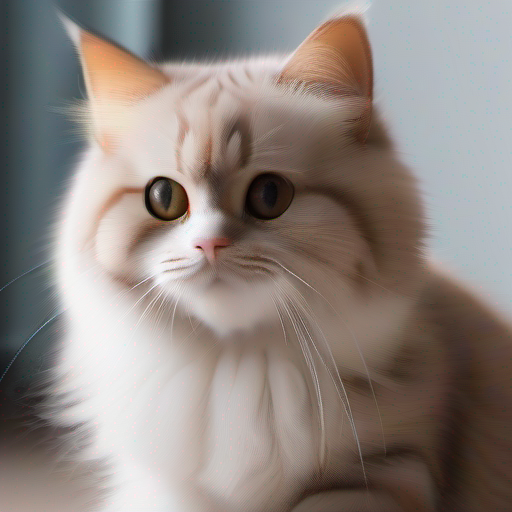

In [4]:
import numpy as np

prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"
image = text2image_pipe(prompt, num_inference_steps=15, height=512, width=512, generator=np.random.RandomState(314)).images[0]
image.save("cat.png")
image

In [5]:
del text2image_pipe
gc.collect()

291

### Run Image2Image generation pipeline

In [6]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline

image2image_pipe = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(model_dir)

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder_2...
Compiling the text_encoder...
Compiling the vae_encoder...


/home/ea/work/ov_notebooks_env/lib/python3.8/site-packages/optimum/pipelines/diffusers/pipeline_utils.py:64: FutureWarning: The preprocess method is deprecated and will be removed in a future version. Please use VaeImageProcessor.preprocess instead
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

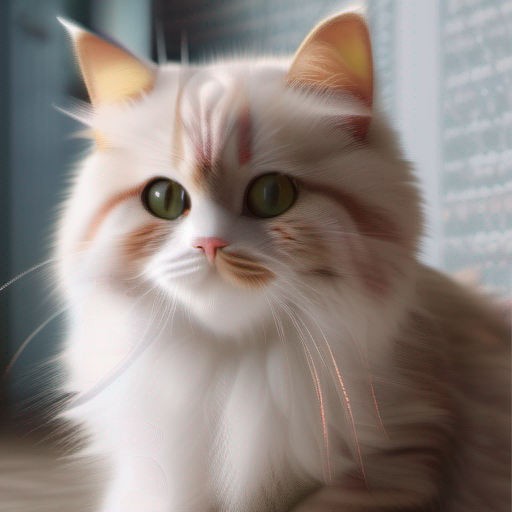

In [7]:
photo_prompt = f"professional photo of a cat, extremely detailed, hyper realistic, best quality, full hd"
photo_image = image2image_pipe(photo_prompt, image=image, num_inference_steps=50, generator=np.random.RandomState(356)).images[0]
photo_image.save("photo_cat.png")
photo_image

In [8]:
del image2image_pipe
gc.collect()

190

## SDXL Refiner model

In [9]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline, OVStableDiffusionXLPipeline
from pathlib import Path

refiner_model_id = "stabilityai/stable-diffusion-xl-refiner-1.0"
refiner_model_dir = Path("openvino-sd-xl-refiner-1.0")


if not refiner_model_dir.exists():
    refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_id, export=True, compile=False)
    refiner.save_pretrained(refiner_model_dir)
    del refiner
    gc.collect()

In [10]:
import numpy as np
import gc
model_dir = Path("openvino-sd-xl-base-1.0")
base = OVStableDiffusionXLPipeline.from_pretrained(model_dir)
prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"
latents = base(prompt, num_inference_steps=15, height=512, width=512, generator=np.random.RandomState(314), output_type="latent").images[0]

del base
gc.collect()

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder...
Compiling the text_encoder_2...
Compiling the vae_encoder...


  0%|          | 0/15 [00:00<?, ?it/s]

216

In [11]:
refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_dir)

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder_2...
Compiling the vae_encoder...


In [13]:
image = refiner(prompt=prompt, image=latents[None, :], num_inference_steps=15, generator=np.random.RandomState(314)).images[0]
image
image.save("cat_refined.png")

  0%|          | 0/4 [00:00<?, ?it/s]

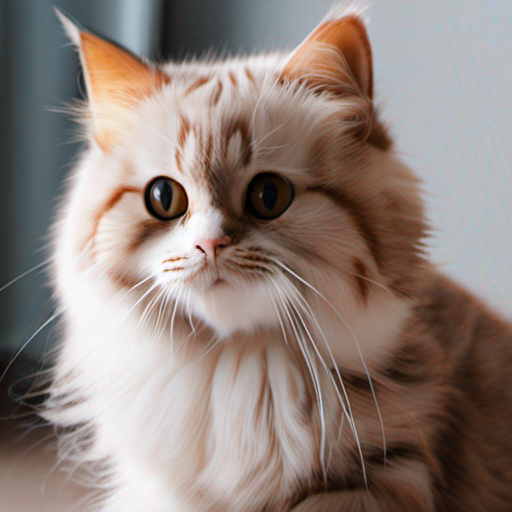